In [3]:
%env WORKDIR=/tmp/vault
%env VAULT_K8S_NAMESPACE=vault
%env VAULT_HELM_RELEASE_NAME=vault
%env VAULT_SERVICE_NAME=vault-internal 
%env K8S_CLUSTER_NAME=cluster.local 

env: WORKDIR=/tmp/vault
env: VAULT_K8S_NAMESPACE=vault
env: VAULT_HELM_RELEASE_NAME=vault
env: VAULT_SERVICE_NAME=vault-internal
env: K8S_CLUSTER_NAME=cluster.local


In [2]:
%%bash
cat ${WORKDIR}/cluster-keys.json | jq -r ".root_token"

hvs.RD8vp71RDNbGBTFcKJuD1sFV


## https://developer.hashicorp.com/vault/docs/auth/jwt/oidc-providers/kubernetes

In [3]:
%%bash
kubectl create clusterrolebinding oidc-reviewer  \
   --clusterrole=system:service-account-issuer-discovery \
   --group=system:unauthenticated


clusterrolebinding.rbac.authorization.k8s.io/oidc-reviewer created


In [4]:
%%bash
ISSUER="$(kubectl get --raw /.well-known/openid-configuration | jq -r '.issuer')"
echo $ISSUER

https://kubernetes.default.svc.cluster.local


In [14]:
%%bash
kubectl exec vault-0 -n vault -- vault login hvs.RD8vp71RDNbGBTFcKJuD1sFV
kubectl exec vault-0 -n vault -- vault auth enable jwt
kubectl exec vault-0 -n vault -- vault write auth/jwt/config \
   oidc_discovery_url=https://kubernetes.default.svc.cluster.local \
   oidc_discovery_ca_pem=@/var/run/secrets/kubernetes.io/serviceaccount/ca.crt

Success! You are now authenticated. The token information displayed below
is already stored in the token helper. You do NOT need to run "vault login"
again. Future Vault requests will automatically use this token.

Key                  Value
---                  -----
token                hvs.RD8vp71RDNbGBTFcKJuD1sFV
token_accessor       nRP3p1AKjR5LZpDuJGKSKV4G
token_duration       ∞
token_renewable      false
token_policies       ["root"]
identity_policies    []
policies             ["root"]


Error enabling jwt auth: Error making API request.

URL: POST https://127.0.0.1:8200/v1/sys/auth/jwt
Code: 400. Errors:

* path is already in use at jwt/
command terminated with exit code 2


Success! Data written to: auth/jwt/config


In [38]:

! kubectl get --raw "$(kubectl get --raw /.well-known/openid-configuration | jq -r '.jwks_uri' | sed -r 's/.*\.[^/]+(.*)/\1/')" | jq -r
! pip3 install pycryptodome

{
  "keys": [
    {
      "use": "sig",
      "kty": "RSA",
      "kid": "tk1afHmOlH6WXDmueZ7Qep6flST1vGLauAOYspfPO6o",
      "alg": "RS256",
      "n": "zBNt_YeRx4WwYWtNwoDhu08O1rPabTZCE7yeEMOe4HCiJb6QSOYocR2NPE3riag878mMjk5NqWvJ6mOhm3z6jnGRUSSc0ZKt5Jld0a4ZA0Ju361_cDQVEy88Tw4a_0kiS8-tmKT2LimPbKMbQVNZM5rgyiG-CFt0hm6edP5P_tmQN93P_m7jBq9G-4NWHGm0G1Y4oMEsa4h5dVeMX4f9-9zxLdlDVcT3JKdA4xH_0zPXfZK0BXi642sSqIV8fyQXXNrhfIwgGrPEFj4_PEJ3XdDy_FQRVGQDLAs8kWHSJLtkmX4yebrPbMgBRxWUSCg-2mtiX1ZOvU96k9YRVKLKjw",
      "e": "AQAB"
    }
  ]
}
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


In [1]:
import base64
import binascii
from Crypto.PublicKey import RSA

jwks_key = {
  "keys": [
    {
      "use": "sig",
      "kty": "RSA",
      "kid": "tk1afHmOlH6WXDmueZ7Qep6flST1vGLauAOYspfPO6o",
      "alg": "RS256",
      "n": "zBNt_YeRx4WwYWtNwoDhu08O1rPabTZCE7yeEMOe4HCiJb6QSOYocR2NPE3riag878mMjk5NqWvJ6mOhm3z6jnGRUSSc0ZKt5Jld0a4ZA0Ju361_cDQVEy88Tw4a_0kiS8-tmKT2LimPbKMbQVNZM5rgyiG-CFt0hm6edP5P_tmQN93P_m7jBq9G-4NWHGm0G1Y4oMEsa4h5dVeMX4f9-9zxLdlDVcT3JKdA4xH_0zPXfZK0BXi642sSqIV8fyQXXNrhfIwgGrPEFj4_PEJ3XdDy_FQRVGQDLAs8kWHSJLtkmX4yebrPbMgBRxWUSCg-2mtiX1ZOvU96k9YRVKLKjw",
      "e": "AQAB"
    }
  ]
}

# Select the specific key from the JWKS
selected_key = jwks_key['keys'][0]

# Decode the base64 values of 'n' and 'e' to bytes
n_bytes = base64.urlsafe_b64decode(selected_key['n'] + '==')
e_bytes = base64.urlsafe_b64decode(selected_key['e'] + '==')

# Construct an RSA key
rsa_key = RSA.construct((int(binascii.hexlify(n_bytes), 16), int(binascii.hexlify(e_bytes), 16)))

# Convert the RSA key to PEM format
pem_key = rsa_key.exportKey(format='PEM')

print(pem_key.decode('utf-8'))


-----BEGIN PUBLIC KEY-----
MIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAzBNt/YeRx4WwYWtNwoDh
u08O1rPabTZCE7yeEMOe4HCiJb6QSOYocR2NPE3riag878mMjk5NqWvJ6mOhm3z6
jnGRUSSc0ZKt5Jld0a4ZA0Ju361/cDQVEy88Tw4a/0kiS8+tmKT2LimPbKMbQVNZ
M5rgyiG+CFt0hm6edP5P/tmQN93P/m7jBq9G+4NWHGm0G1Y4oMEsa4h5dVeMX4f9
+9zxLdlDVcT3JKdA4xH/0zPXfZK0BXi642sSqIV8fyQXXNrhfIwgGrPEFj4/PEJ3
XdDy/FQRVGQDLAs8kWHSJLtkmX4yebrPbMgBRxWUSCg+2mtiX1ZOvU96k9YRVKLK
jwIDAQAB
-----END PUBLIC KEY-----


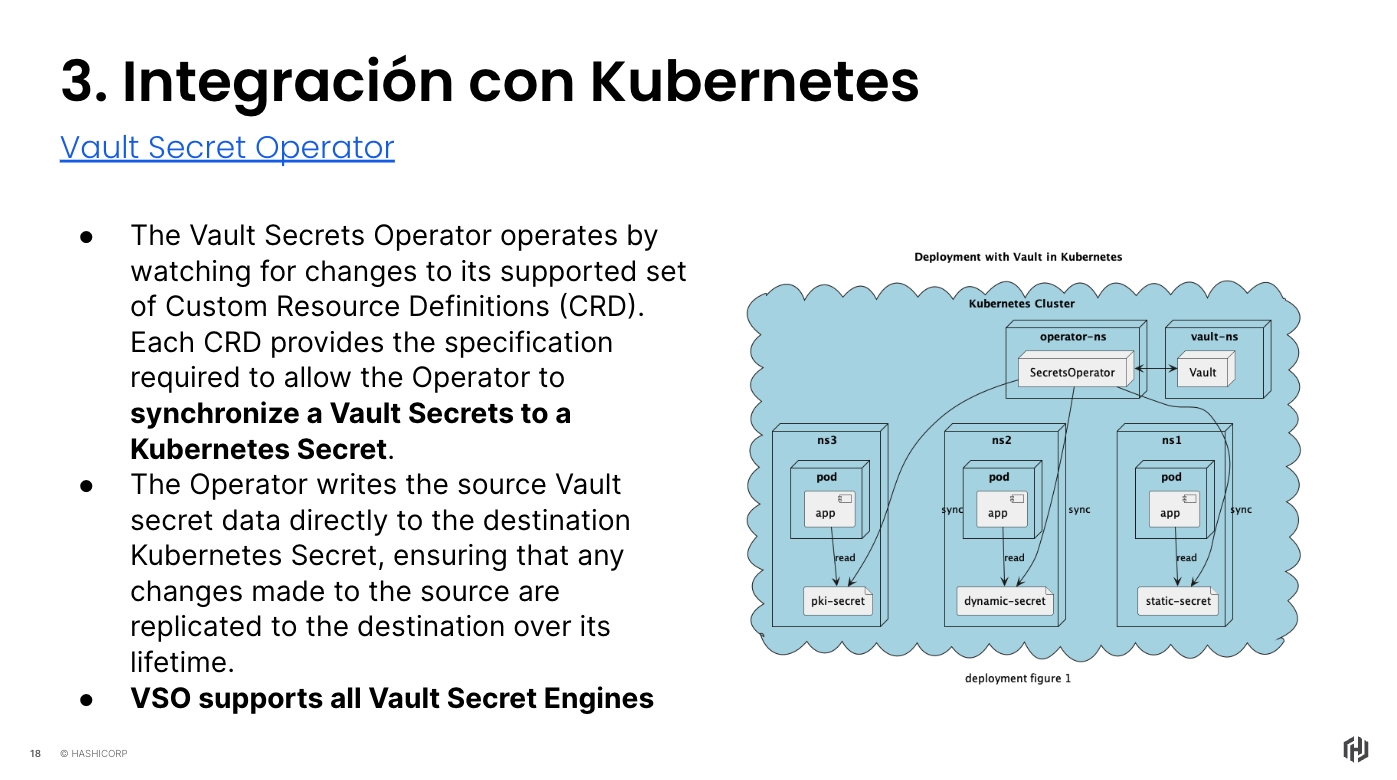

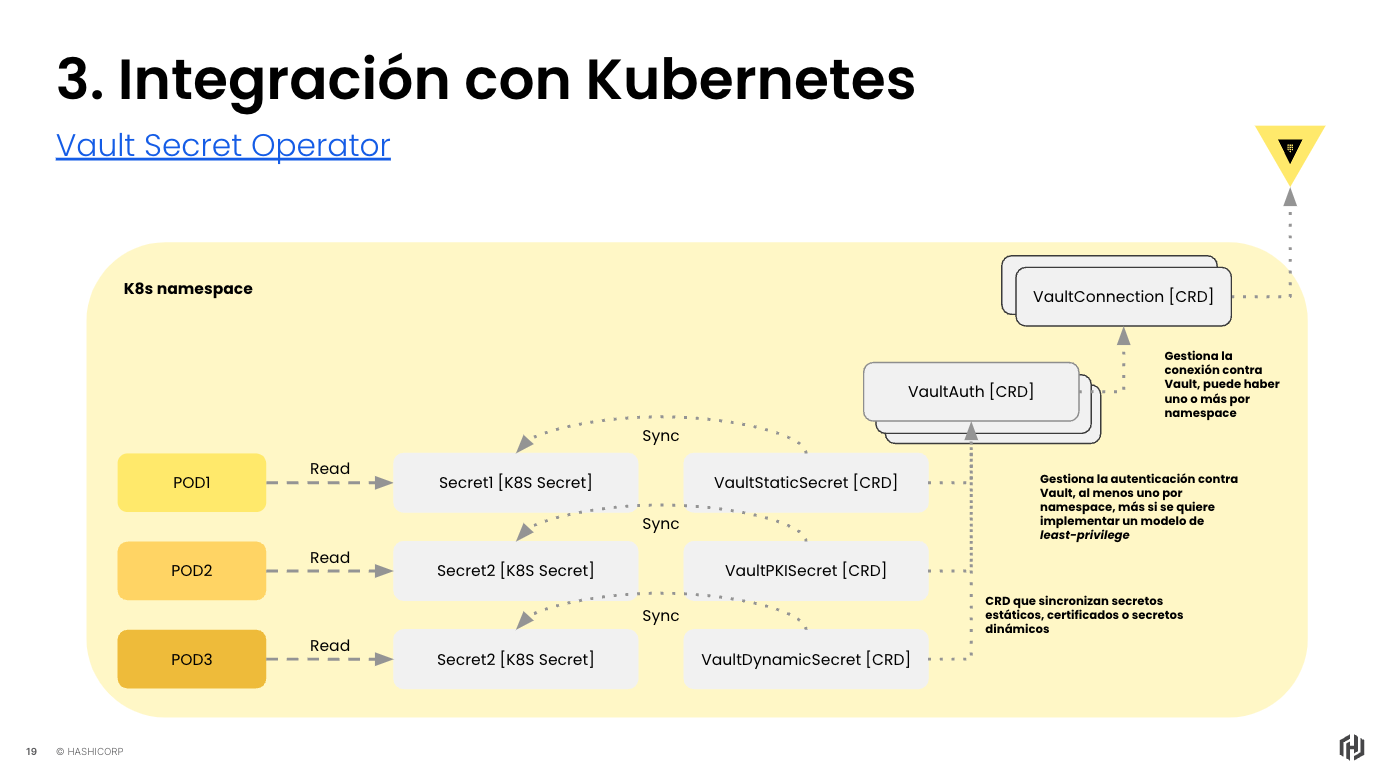

## Ahora usando Vault Secret Operator

In [4]:
%%bash
cat ${WORKDIR}/cluster-keys.json | jq -r ".root_token"

hvs.RD8vp71RDNbGBTFcKJuD1sFV


In [5]:
%env VAULT_ADDR=https://127.0.0.1:8200
%env VAULT_TOKEN=hvs.RD8vp71RDNbGBTFcKJuD1sFV
%env VAULT_CACERT=/tmp/vault/vault.ca

env: VAULT_ADDR=https://127.0.0.1:8200
env: VAULT_TOKEN=hvs.RD8vp71RDNbGBTFcKJuD1sFV
env: VAULT_CACERT=/tmp/vault/vault.ca


In [ ]:
%%bash
# Role associated to default service account in the app namespace
vault write auth/kubernetes/role/role1 \
    bound_service_account_names=default \
    bound_service_account_namespaces=vault \
    policies=devk8s \
    ttl=24h


In [ ]:
%%bash
# Role associated to default service account in the app namespace
vault write auth/kubernetes/role/role2 \
    bound_service_account_names=default \
    bound_service_account_namespaces=default \
    policies=devk8s \
    ttl=24h

In [6]:
%%bash
vault policy write devk8s - <<EOF
path "kvv2/*" {
  capabilities = ["read"]
}
EOF


Success! Uploaded policy: devk8s


In [7]:
%%bash
vault secrets enable -path=kvv2 kv-v2

Success! Enabled the kv-v2 secrets engine at: kvv2/


In [8]:
%%bash
vault kv put kvv2/webapp/config username="static-user" password="static-password"

===== Secret Path =====
kvv2/data/webapp/config

======= Metadata =======
Key                Value
---                -----
created_time       2023-10-11T11:56:00.798923636Z
custom_metadata    <nil>
deletion_time      n/a
destroyed          false
version            1


### Instalando el VSO usando helm

In [9]:
%%bash
helm repo add hashicorp https://helm.releases.hashicorp.com
helm repo update hashicorp
helm install --version 0.3.1 --namespace $VAULT_K8S_NAMESPACE vault-secrets-operator hashicorp/vault-secrets-operator


"hashicorp" already exists with the same configuration, skipping
Hang tight while we grab the latest from your chart repositories...
...Successfully got an update from the "hashicorp" chart repository
Update Complete. ⎈Happy Helming!⎈
NAME: vault-secrets-operator
LAST DEPLOYED: Wed Oct 11 13:57:37 2023
NAMESPACE: vault
STATUS: deployed
REVISION: 1


In [13]:
%%bash
## VaultConnection Custom Resource
# https://developer.hashicorp.com/vault/docs/platform/k8s/vso/sources/vault
cat > vso_crd.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1beta1
kind: VaultConnection
metadata:
  namespace: vault
  name: example
spec:
  # required configuration
  # address to the Vault server.
  address: https://vault.vault.svc.cluster.local:8200

  # optional configuration
  # HTTP headers to be included in all Vault requests.
  # headers: []
  # TLS server name to use as the SNI host for TLS connections.
  # tlsServerName: ""
  # skip TLS verification for TLS connections to Vault.
  skipTLSVerify: true
  # the trusted PEM encoded CA certificate chain stored in a Kubernetes Secret
  # caCertSecretRef: ""

EOF
kubectl apply -f vso_crd.yaml
echo '---'
kubectl describe VaultConnection example -n vault


vaultconnection.secrets.hashicorp.com/example created
---
Name:         example
Namespace:    vault
Labels:       <none>
Annotations:  <none>
API Version:  secrets.hashicorp.com/v1beta1
Kind:         VaultConnection
Metadata:
  Creation Timestamp:  2023-10-11T12:02:42Z
  Finalizers:
    vaultconnection.secrets.hashicorp.com/finalizer
  Generation:        1
  Resource Version:  11619
  UID:               c5c2d3eb-f402-480e-9cc5-9d79a2b684f2
Spec:
  Address:          https://vault.vault.svc.cluster.local:8200
  Skip TLS Verify:  true
Status:
  Valid:  true
Events:
  Type    Reason    Age   From             Message
  ----    ------    ----  ----             -------
  Normal  Accepted  0s    VaultConnection  VaultConnection accepted


In [57]:
%%bash
## VaultConnection Custom Resource
# https://developer.hashicorp.com/vault/docs/platform/k8s/vso/sources/vault
export NAMESPACE=vault111
kubectl create ns $NAMESPACE
cat > vso_crd_${NAMESPACE}.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1beta1
kind: VaultConnection
metadata:
  namespace: $NAMESPACE
  name: example
spec:
  # required configuration
  # address to the Vault server.
  address: https://vault.vault.svc.cluster.local:8200

  # optional configuration
  # HTTP headers to be included in all Vault requests.
  # headers: []
  # TLS server name to use as the SNI host for TLS connections.
  # tlsServerName: ""
  # skip TLS verification for TLS connections to Vault.
  skipTLSVerify: true
  # the trusted PEM encoded CA certificate chain stored in a Kubernetes Secret
  # caCertSecretRef: ""

EOF
kubectl apply -f vso_crd_${NAMESPACE}.yaml
echo '---'
kubectl describe VaultConnection example -n $NAMESPACE


Error from server (AlreadyExists): namespaces "vault111" already exists


vaultconnection.secrets.hashicorp.com/example created
---
Name:         example
Namespace:    vault111
Labels:       <none>
Annotations:  <none>
API Version:  secrets.hashicorp.com/v1beta1
Kind:         VaultConnection
Metadata:
  Creation Timestamp:  2023-10-11T13:54:07Z
  Finalizers:
    vaultconnection.secrets.hashicorp.com/finalizer
  Generation:        1
  Resource Version:  20130
  UID:               c939b900-b3e5-4052-869b-7cf79174e800
Spec:
  Address:          https://vault.vault.svc.cluster.local:8200
  Skip TLS Verify:  true
Events:             <none>


In [67]:
%%bash
# https://developer.hashicorp.com/vault/docs/platform/k8s/vso/api-reference#vaultauthconfigjwt
export NAMESPACE=vault111
cat > vaultauth_crd_${NAMESPACE}.yaml <<EOF
# kubectl create sa test -n $NAMESPACE
---
apiVersion: secrets.hashicorp.com/v1beta1
kind: VaultAuth
metadata:
  namespace: $NAMESPACE
  name: example
spec:
  # required configuration
  # VaultConnectionRef of the corresponding VaultConnection CustomResource.
  # If no value is specified the Operator will default to the `default` VaultConnection,
  # configured in its own Kubernetes namespace.
  vaultConnectionRef: example
  # Method to use when authenticating to Vault.
  method: jwt
  # Mount to use when authenticating to auth method.
  mount: jwt
  # allowedNamespaces: []{"*"}
  # Kubernetes specific auth configuration, requires that the Method be set to kubernetes.
  jwt:
    # role to use when authenticating to Vault
    role: my-role3
    # ServiceAccount to use when authenticating to Vault
    # it is recommended to always provide a unique serviceAccount per Pod/application
    serviceAccount: default
    audiences: ["https://kubernetes.default.svc.cluster.local"]

  # optional configuration
  # Vault namespace where the auth backend is mounted (requires Vault Enterprise)
  # namespace: ""
  # Params to use when authenticating to Vault
  # params: []
  # HTTP headers to be included in all Vault authentication requests.
  # headers: []
EOF

kubectl apply -f vaultauth_crd_${NAMESPACE}.yaml
echo '---'
kubectl describe VaultAuth example -n $NAMESPACE

bash: line 3: default: command not found


vaultauth.secrets.hashicorp.com/example configured
---
Name:         example
Namespace:    vault111
Labels:       <none>
Annotations:  <none>
API Version:  secrets.hashicorp.com/v1beta1
Kind:         VaultAuth
Metadata:
  Creation Timestamp:  2023-10-11T13:55:47Z
  Finalizers:
    vaultauth.secrets.hashicorp.com/finalizer
  Generation:        2
  Resource Version:  21167
  UID:               166e17b6-e176-4310-9b5a-4de995664ceb
Spec:
  Jwt:
    Audiences:
      https://kubernetes.default.svc.cluster.local
    Role:                      my-role3
    Service Account:           default
    Token Expiration Seconds:  600
  Method:                      jwt
  Mount:                       jwt
  Vault Connection Ref:        example
Status:
  Error:  
  Valid:  true
Events:
  Type    Reason    Age               From       Message
  ----    ------    ----              ----       -------
  Normal  Accepted  0s (x2 over 10m)  VaultAuth  Successfully handled VaultAuth resource request


In [47]:
%%bash
# https://developer.hashicorp.com/vault/docs/platform/k8s/vso/api-reference#vaultauthconfigjw

cat > vaultauth_crd.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1beta1
kind: VaultAuth
metadata:
  namespace: vault
  name: example
spec:
  # required configuration
  # VaultConnectionRef of the corresponding VaultConnection CustomResource.
  # If no value is specified the Operator will default to the `default` VaultConnection,
  # configured in its own Kubernetes namespace.
  vaultConnectionRef: example
  # Method to use when authenticating to Vault.
  method: jwt
  # Mount to use when authenticating to auth method.
  mount: jwt
  # allowedNamespaces: []{"*"}
  # Kubernetes specific auth configuration, requires that the Method be set to kubernetes.
  jwt:
    # role to use when authenticating to Vault
    role: my-role3
    # ServiceAccount to use when authenticating to Vault
    # it is recommended to always provide a unique serviceAccount per Pod/application
    serviceAccount: test
    audiences: ["https://kubernetes.default.svc.cluster.local"]

  # optional configuration
  # Vault namespace where the auth backend is mounted (requires Vault Enterprise)
  # namespace: ""
  # Params to use when authenticating to Vault
  # params: []
  # HTTP headers to be included in all Vault authentication requests.
  # headers: []
EOF

kubectl apply -f vaultauth_crd.yaml
echo '---'
kubectl describe VaultAuth example -n vault

bash: line 2: default: command not found


vaultauth.secrets.hashicorp.com/example configured
---
Name:         example
Namespace:    vault
Labels:       <none>
Annotations:  <none>
API Version:  secrets.hashicorp.com/v1beta1
Kind:         VaultAuth
Metadata:
  Creation Timestamp:  2023-10-11T13:34:06Z
  Finalizers:
    vaultauth.secrets.hashicorp.com/finalizer
  Generation:        3
  Resource Version:  19228
  UID:               0d8a4a5f-bcce-44fb-821b-f10da27d7a5d
Spec:
  Jwt:
    Audiences:
      https://kubernetes.default.svc.cluster.local
    Role:                      my-role3
    Service Account:           test
    Token Expiration Seconds:  600
  Method:                      jwt
  Mount:                       jwt
  Vault Connection Ref:        example
Status:
  Error:  
  Valid:  true
Events:
  Type    Reason    Age                From       Message
  ----    ------    ----               ----       -------
  Normal  Accepted  0s (x3 over 9m4s)  VaultAuth  Successfully handled VaultAuth resource request


## CRD Static Secret

In [52]:
%%bash
## Support KVv1 and KVv2
cat > secret.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1beta1
kind: VaultStaticSecret
metadata:
  namespace: vault
  name: example2
spec:
  vaultAuthRef: example
  mount: kvv2
  type: kv-v2
  path: webapp/config
  refreshAfter: 60s
  destination:
    create: true
    name: secret
EOF
kubectl apply -f secret.yaml
echo '---'
kubectl describe VaultStaticSecret example2 -n vault
echo '---'
sleep 5
kubectl get secret secret -n vault -o yaml


vaultstaticsecret.secrets.hashicorp.com/example2 created
---
Name:         example2
Namespace:    vault
Labels:       <none>
Annotations:  <none>
API Version:  secrets.hashicorp.com/v1beta1
Kind:         VaultStaticSecret
Metadata:
  Creation Timestamp:  2023-10-11T13:47:01Z
  Generation:          1
  Resource Version:    19552
  UID:                 dd021e18-8775-4e20-8693-23633309767a
Spec:
  Destination:
    Create:          true
    Name:            secret
  Hmac Secret Data:  true
  Mount:             kvv2
  Path:              webapp/config
  Refresh After:     60s
  Type:              kv-v2
  Vault Auth Ref:    example
Status:
  Secret MAC:  mxDCvrAQ79Ur7CRQmOpG+1eceQEKiQfskEFPxa7MUxY=
Events:
  Type    Reason        Age   From               Message
  ----    ------        ----  ----               -------
  Normal  SecretSynced  0s    VaultStaticSecret  Secret synced
---
apiVersion: v1
data:
  _raw: eyJkYXRhIjp7InBhc3N3b3JkIjoic3RhdGljLXBhc3N3b3JkIiwidXNlcm5hbWUiOiJzdGF0aWMtdXNlc

In [68]:
%%bash
## Support KVv1 and KVv2
export NAMESPACE=vault111
cat > secret_${NAMESPACE}.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1beta1
kind: VaultStaticSecret
metadata:
  namespace: $NAMESPACE
  name: example2
spec:
  vaultAuthRef: example
  mount: kvv2
  type: kv-v2
  path: webapp/config
  refreshAfter: 60s
  destination:
    create: true
    name: secret
EOF
kubectl apply -f secret_${NAMESPACE}.yaml
echo '---'
kubectl describe VaultStaticSecret example2 -n $NAMESPACE
echo '---'
sleep 5
kubectl get secret secret -n $NAMESPACE -o yaml


vaultstaticsecret.secrets.hashicorp.com/example2 unchanged
---
Name:         example2
Namespace:    vault111
Labels:       <none>
Annotations:  <none>
API Version:  secrets.hashicorp.com/v1beta1
Kind:         VaultStaticSecret
Metadata:
  Creation Timestamp:  2023-10-11T14:02:29Z
  Generation:          1
  Resource Version:    21317
  UID:                 84803102-99e2-4704-b23b-efd4f1ca9c7b
Spec:
  Destination:
    Create:          true
    Name:            secret
  Hmac Secret Data:  true
  Mount:             kvv2
  Path:              webapp/config
  Refresh After:     60s
  Type:              kv-v2
  Vault Auth Ref:    example
Status:
  Secret MAC:  mxDCvrAQ79Ur7CRQmOpG+1eceQEKiQfskEFPxa7MUxY=
Events:
  Type     Reason                  Age                 From                Message
  ----     ------                  ----                ----                -------
  Warning  Unrecoverable           14m (x16 over 17m)  vaultClientFactory  Failed to get cacheKey from obj, err=either s

In [41]:
%%bash
echo "namespace: Vault"
kubectl get secrets -n vault

namespace: Vault
NAME                                           TYPE                 DATA   AGE
sh.helm.release.v1.vault-secrets-operator.v1   helm.sh/release.v1   1      97m
sh.helm.release.v1.vault.v1                    helm.sh/release.v1   1      5h23m
static-secret1                                 Opaque               3      77s
vault-ent-license                              Opaque               1      5h24m
vault-ha-tls                                   Opaque               3      5h24m
vso-cc-storage-hmac-key                        Opaque               1      97m
namespace: Default


No resources found in default namespace.


In [51]:
%%bash
cat > mypod.yaml <<EOF
apiVersion: v1
kind: Pod
metadata:
  name: mypod
  namespace: vault
spec:
  containers:
  - name: mypod
    image: nginx
    volumeMounts:
    - name: foo
      mountPath: "/etc/foo"
      readOnly: true
  volumes:
  - name: foo
    secret:
      secretName: static-secret1
      optional: true
EOF
kubectl delete -f mypod.yaml
sleep 10

# https://developer.hashicorp.com/vault/tutorials/kubernetes/vault-secrets-operator

pod "mypod" deleted


In [43]:
%%bash 
kubectl exec mypod -n vault -- ls /etc/foo
echo ""
echo "------"
kubectl exec mypod -n vault -- cat /etc/foo/_raw

_raw
password
username

------
{"data":{"password":"static-password","username":"static-user"},"metadata":{"created_time":"2023-10-11T11:56:00.798923636Z","custom_metadata":null,"deletion_time":"","destroyed":false,"version":1}}

### mostrando que la serviceaccount del Pod no influye (el acceso viene impersonado por Vault-Auth CRD)

In [ ]:
%%bash
cat > mypod3.yaml <<EOF
apiVersion: v1
kind: Pod
metadata:
  name: mypod3
  namespace: vault
  # Using a different service account
spec:
  serviceAccountName: vault
  containers:
  - name: mypod
    image: redis
    volumeMounts:
    - name: foo
      mountPath: "/etc/foo"
      readOnly: true
  volumes:
  - name: foo
    secret:
      secretName: static-secret1
      optional: true
EOF
kubectl apply -f mypod3.yaml

In [ ]:
%%bash 
sleep 10 
kubectl exec   mypod3 -n vault -- cat /etc/foo/username
echo ""
echo "------"
kubectl exec mypod3 -n vault -- cat /etc/foo/password

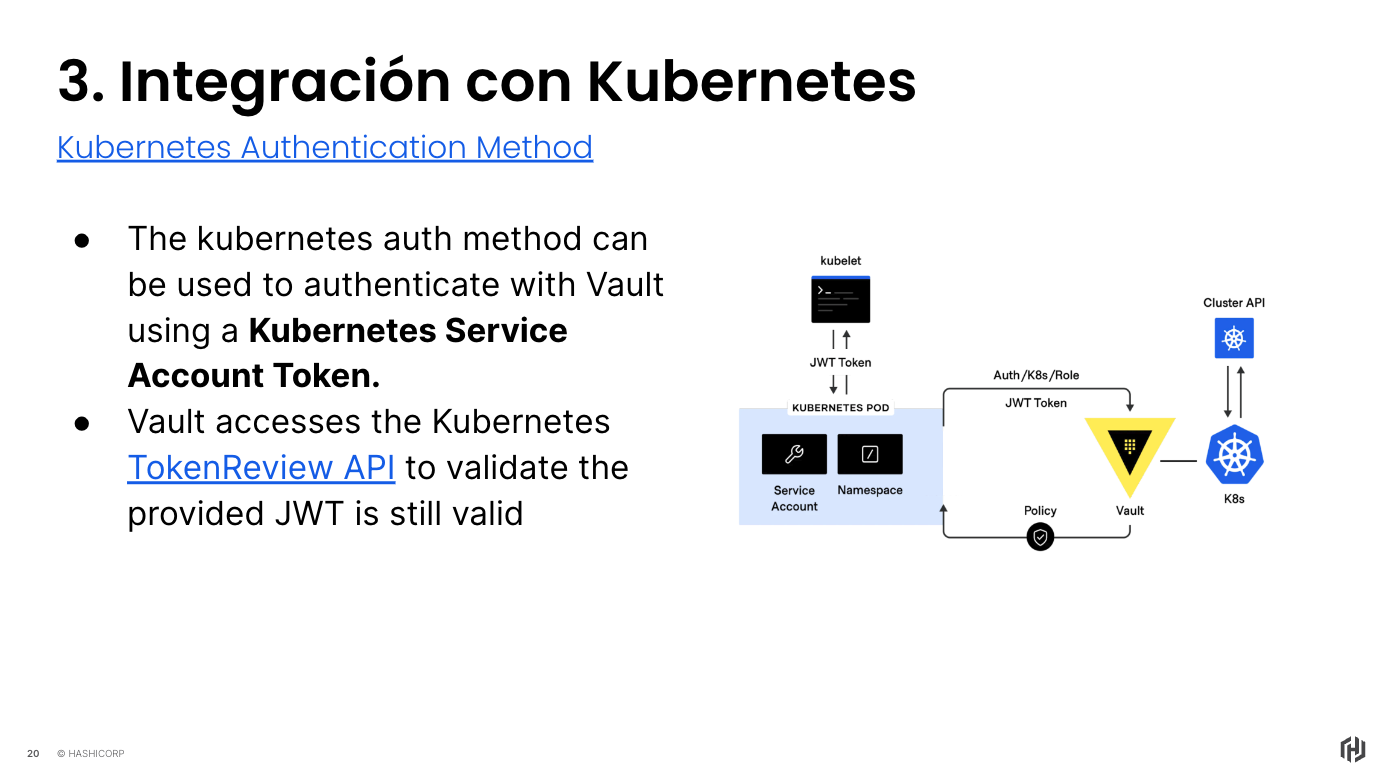

## ¿Cómo funciona la autenticación de Kubernetes?

## (Tras crear la dB engine) Dynamic Secrets

In [ ]:
%%bash

# Actualizar la políticas con permisos de lectura al path de la database
vault policy write devk8s - <<EOF
path "kvv2/*" {
  capabilities = ["read"]
}
path "database/creds/readonly" {
  capabilities = [ "read"]
}
EOF


cat > dynamic_secret.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1alpha1
kind: VaultDynamicSecret
metadata:
  namespace: default
  name: exampled
spec:
  vaultAuthRef: example2
  mount: database
  role: readonly
  destination:
    create: true
    name: dynamic-secret1
EOF

kubectl apply -f dynamic_secret.yaml
echo '---'
sleep 3
kubectl describe VaultDynamicSecret exampled
echo '---'
sleep 5
kubectl get secret dynamic-secret1 -o yaml

In [ ]:
%%bash
cat > mypod_db.yaml <<EOF
apiVersion: v1
kind: Pod
metadata:
  name: mypoddb
  # Using a different service account
spec:
  containers:
  - name: mypod
    image: redis
    volumeMounts:
    - name: foo
      mountPath: "/etc/foo"
      readOnly: true
  volumes:
  - name: foo
    secret:
      secretName: dynamic-secret1
      optional: true
EOF


# Despliega el POD
kubectl apply -f mypod_db.yaml
# Espera a que despliegue
sleep 10 
# Chequea secretos
kubectl exec mypoddb  -- ls /etc/foo/
echo ""
echo "------"
kubectl exec mypoddb -- cat /etc/foo/_raw

## Tras crear la LDAP engine

In [ ]:
%%bash 

# Actualizar la políticas con permisos de lectura al path de la ldap engine
vault policy write devk8s - <<EOF
path "kvv2/*" {
  capabilities = ["read"]
}
path "database/creds/readonly" {
  capabilities = [ "read"]
}
path "ldap/creds/dynamic" {
  capabilities = [ "read"]
}
EOF

cat > dynamic_secret2.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1alpha1
kind: VaultDynamicSecret
metadata:
  namespace: default
  name: exampled2
spec:
  vaultAuthRef: example2
  mount: ldap
  role: dynamic
  destination:
    create: true
    name: dynamic-secret2
EOF

kubectl apply -f dynamic_secret2.yaml
echo '---'
sleep 3
kubectl describe VaultDynamicSecret exampled2
echo '---'
sleep 5
kubectl get secret dynamic-secret2 -o yaml

In [ ]:
%%bash
cat > mypod_ldap.yaml <<EOF
apiVersion: v1
kind: Pod
metadata:
  name: mypodldap
  # Using a different service account
spec:
  containers:
  - name: mypod
    image: redis
    volumeMounts:
    - name: foo
      mountPath: "/etc/foo"
      readOnly: true
  volumes:
  - name: foo
    secret:
      secretName: dynamic-secret2
      optional: true
EOF
kubectl apply -f mypod_ldap.yaml

In [ ]:
%%bash 
sleep 10 
kubectl exec mypodldap  -- ls /etc/foo/
echo ""
echo "------"
kubectl exec mypodldap -- cat /etc/foo/_raw